In [1]:
train_data = './data/train'
train_labels = './data/train.csv'
val_data = './data/val'
val_labels = './data/val.csv'

In [2]:
from utilities import GestureDataGenerator, plot_training_history, set_seed, get_callbacks, set_memorry_limit_for_tf
set_seed(seed=42)

2024-12-02 18:48:21.927699: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 18:48:22.027478: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Random seed set to 42


In [3]:
load_fraction = 1.0             # Full data load
batch_size = 16                 # We are low on resources. We will go slow and steady.
image_size = (224, 224)

# Initialize the generator
train_generator = GestureDataGenerator(
    data_path=train_data,
    labels_csv=train_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations={
        'rotation': 5,       # Rotate up to ±5 degrees
        'brightness': True,  # Random brightness adjustment
        'contrast': True,    # Random contrast adjustment
        'blur': True         # Apply Gaussian blur
    },    
    shuffle=True,
    load_fraction=load_fraction,
    debug=False,
    use_mediapipe=False,
)

val_generator = GestureDataGenerator(
    data_path=val_data,
    labels_csv=val_labels,
    batch_size=batch_size,
    image_size=image_size,
    augmentations=None,
    shuffle=False,
    load_fraction=1.0,
    debug=False,
    use_mediapipe=False,
)

# Get the first batch
X, y = train_generator[0]

# Print outputs
print("Input batch shape (X):", X.shape)  # Expected shape: (batch_size, sequence_length, 224, 224, 3)
print("Labels batch shape (y):", y.shape)  # Expected shape: (batch_size, num_classes)
print("First label in batch (one-hot):", y[0])

42 batches created, each of size 16, with 663 sequences of 30 images each. Use MediaPipe: False
7 batches created, each of size 16, with 100 sequences of 30 images each. Use MediaPipe: False
Input batch shape (X): (16, 30, 224, 224, 3)
Labels batch shape (y): (16, 5)
First label in batch (one-hot): [0. 0. 0. 1. 0.]


In [4]:
# Define parameters
sequence_length = train_generator.sequence_length  # Frames per video (from generator)
image_size = train_generator.image_size            # Image size (height, width)
num_classes = train_generator.num_classes          # Number of gesture classes
input_shape = (sequence_length, image_size[0], image_size[1], 3)  # Conv3D input shape

In [10]:
from tensorflow.keras import layers, models

# Define the CNN+LSTM model
model = models.Sequential([
    layers.Input(shape=input_shape),  # Input shape: (timesteps, height, width, channels)

    # CNN layers for feature extraction
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),  # Normalize activations for better training
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')),
    layers.TimeDistributed(layers.BatchNormalization()),
    layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2), padding='same')),

    # Flatten the 2D feature maps into 1D feature vectors
    layers.TimeDistributed(layers.Flatten()),

    # LSTM layer for temporal sequence modeling
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),  # Use bidirectional for better context

    # Fully connected layers
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Output layer for classification
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 30, 224, 224, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 224, 224, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 112, 112, 32)  0        
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 112, 112, 64)  18496    
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 30, 112, 112, 64)

In [11]:
model_save_location = './best-models/Conv2D-32x64x128+LSTM.keras'

In [12]:
checkpoint_callback, reduce_lr_callback, early_stopping_callback = get_callbacks(filepath = model_save_location)

Epoch 1/5
42/42 [==============================] - 48s 1s/step - loss: 1.8836 - accuracy: 0.2172 - val_loss: 1.6318 - val_accuracy: 0.2100 - lr: 0.0010
Epoch 2/5
42/42 [==============================] - 43s 1s/step - loss: 1.8009 - accuracy: 0.1961 - val_loss: 1.6158 - val_accuracy: 0.1800 - lr: 0.0010
Epoch 3/5
42/42 [==============================] - 45s 1s/step - loss: 1.7100 - accuracy: 0.2187 - val_loss: 1.6026 - val_accuracy: 0.2200 - lr: 0.0010
Epoch 4/5
42/42 [==============================] - 45s 1s/step - loss: 1.7001 - accuracy: 0.1780 - val_loss: 1.6017 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 5/5
42/42 [==============================] - 43s 1s/step - loss: 1.6537 - accuracy: 0.2232 - val_loss: 1.6033 - val_accuracy: 0.2200 - lr: 0.0010


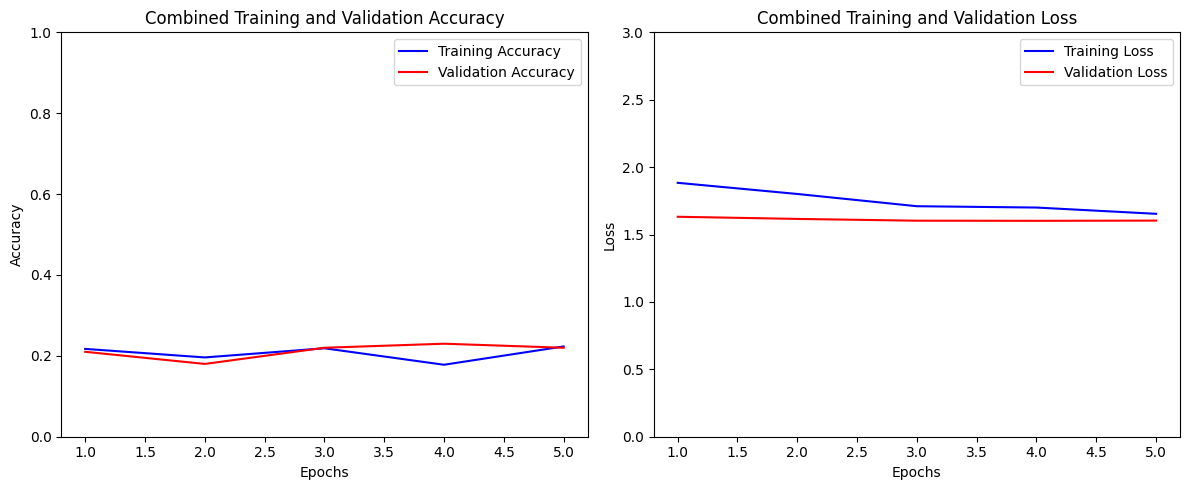

In [13]:
# Train the model
history_1 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1])

Epoch 6/30
42/42 [==============================] - 44s 1s/step - loss: 1.6445 - accuracy: 0.2006 - val_loss: 1.6054 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 7/30
42/42 [==============================] - 43s 1s/step - loss: 1.6377 - accuracy: 0.2202 - val_loss: 1.6049 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 8/30
42/42 [==============================] - 43s 1s/step - loss: 1.6470 - accuracy: 0.2066 - val_loss: 1.6045 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 9/30
42/42 [==============================] - 43s 1s/step - loss: 1.6560 - accuracy: 0.1735 - val_loss: 1.6048 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 10/30
42/42 [==============================] - 43s 1s/step - loss: 1.6237 - accuracy: 0.2051 - val_loss: 1.6117 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 11/30
42/42 [==============================] - 43s 1s/step - loss: 1.6469 - accuracy: 0.1840 - val_loss: 1.6054 - val_accuracy: 0.2300 - lr: 0.0010
Epoch 12/30
42/42 [==============================] - 43s 1s/step - loss: 1.6324 

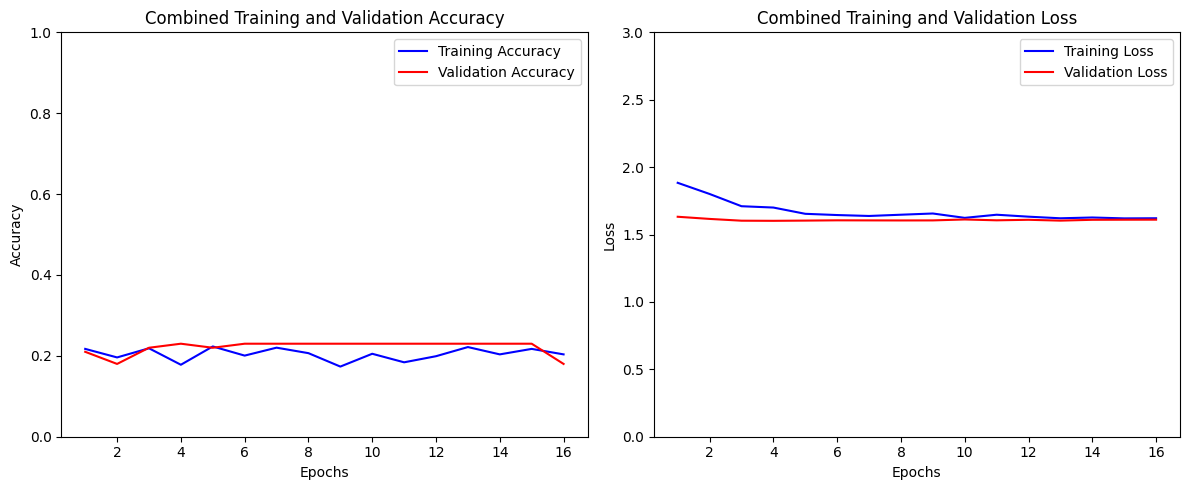

In [14]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_2 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=30,                  # Train for more epochs
    initial_epoch=5,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2])

In [ ]:
model.load_weights(model_save_location)

# Train the model for more epochs
history_3 = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=50,                  # Train for more epochs
    initial_epoch=30,            # Start counting previous epochs
    callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback],
    verbose=1
)

plot_training_history(histories=[history_1, history_2, history_3])

In [ ]:
model.load_weights(model_save_location)

evaluation_results = model.evaluate(val_generator, verbose=1)

for metric, value in zip(model.metrics_names, evaluation_results):
    print(f"{metric}: {value:.4f}")